## Imports

In [2]:
import sys, os
import time
import argparse
import numpy as np
import scipy as sp
from typing import Any, Callable, Dict, List, Tuple

from polycg.Aux.bmat import BlockOverlapMatrix

from polycg.IOPolyMC.iopolymc import write_idb
from polycg.Aux.seq import (
    sequence_file,
    unique_oli_seq,
    unique_olis_in_seq,
    seq2oliseq,
    all_oligomers,
    randseq,
)

from polycg.Aux.aux import load_sequence
from polycg.partials import partial_stiff
from polycg.cg import coarse_grain
from polycg.Transforms.transform_marginals import matrix_rotmarginal,vector_rotmarginal
from polycg.Transforms.transform_statevec import statevec2vecs, vecs2statevec

from polycg.cgnaplus import cgnaplus_bps_params
from polycg.Models.RBPStiff.read_params import GenStiffness
from polycg.SO3 import so3

/home/pol_schiessel/ensk996e/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Generate Stiffness

In [3]:
seqfn = 'Data/JanSeq/Lipfert_7p9kb'
seq = load_sequence(seqfn).lower()

seq = seq[:2001]

unique_sequence = True
method = cgnaplus_bps_params
stiffgen_args = {
    'translations_in_nm': True, 
    'euler_definition': True, 
    'group_split' : True,
    'parameter_set_name' : 'curves_plus',
    'remove_factor_five' : True,
    'rotations_only': True
    }

block_size = 120
overlap_size = 20
tail_size = 20
nbps = len(seq)-1

if overlap_size > nbps:
    overlap_size = nbps-1
if block_size > nbps:
    block_size = nbps

print('Generating partial stiffness matrix with')    
print(f'block_size:   {block_size}')
print(f'overlap_size: {overlap_size}')
print(f'tail_size:    {tail_size}')

gs,stiff = partial_stiff(seq,method,stiffgen_args,block_size=block_size,overlap_size=overlap_size,tail_size=tail_size,closed=False,ndims=3)
        

Generating partial stiffness matrix with
block_size:   120
overlap_size: 20
tail_size:    20
Generating stiffness from bps 0 to 120 (2000 in total).
Generating stiffness from bps 100 to 220 (2000 in total).
Generating stiffness from bps 200 to 320 (2000 in total).
Generating stiffness from bps 300 to 420 (2000 in total).
Generating stiffness from bps 400 to 520 (2000 in total).
Generating stiffness from bps 500 to 620 (2000 in total).
Generating stiffness from bps 600 to 720 (2000 in total).
Generating stiffness from bps 700 to 820 (2000 in total).
Generating stiffness from bps 800 to 920 (2000 in total).
Generating stiffness from bps 900 to 1020 (2000 in total).
Generating stiffness from bps 1000 to 1120 (2000 in total).
Generating stiffness from bps 1100 to 1220 (2000 in total).
Generating stiffness from bps 1200 to 1320 (2000 in total).
Generating stiffness from bps 1300 to 1420 (2000 in total).
Generating stiffness from bps 1400 to 1520 (2000 in total).
Generating stiffness from bp

### Evaluate single stiffmat


In [4]:
print(gs.shape)
print(stiff.shape)

print(type(stiff))
    

(2000, 3)
(6000, 6000)
<class 'scipy.sparse._csc.csc_matrix'>


### Calculate Persistence length

In [5]:
def eval_window(gs,stiff):
    cov = sp.sparse.linalg.inv(stiff)
    S = np.zeros((len(gs),3,3))
    for i in range(len(gs)):
        S[i] = so3.euler2rotmat(gs[i])

    val = 0
    for i in range(len(gs)):
        d = np.zeros(3)
        d[0] = 0.5 * cov[i*3+0,i*3+2]
        d[1] = 0.5 * cov[i*3+1,i*3+2]
        d[2] = 1 - 0.5 * (cov[i*3+0,i*3+0] + cov[i*3+1,i*3+1])
        
        d[0] += -1./24 * (3*cov[i*3+0,i*3+2]*cov[i*3+0,i*3+0]) 
        d[0] += -1./24 * (  cov[i*3+0,i*3+2]*cov[i*3+1,i*3+1] + 2 * cov[i*3+0,i*3+1]*cov[i*3+2,i*3+1]) 
        d[0] += -1./24 * (3*cov[i*3+0,i*3+2]*cov[i*3+2,i*3+2]) 
        
        d[1] += -1./24 * (  cov[i*3+1,i*3+2]*cov[i*3+0,i*3+0] + 2 * cov[i*3+0,i*3+1]*cov[i*3+0,i*3+2]) 
        d[1] += -1./24 * (3*cov[i*3+1,i*3+2]*cov[i*3+1,i*3+1]) 
        d[1] += -1./24 * (3*cov[i*3+1,i*3+2]*cov[i*3+2,i*3+2]) 
        
        d[2] += 1./24 * (  cov[i*3+0,i*3+0]*cov[i*3+2,i*3+2] + 2 * cov[i*3+0,i*3+2]*cov[i*3+0,i*3+2]) 
        d[2] += 1./24 * (  cov[i*3+1,i*3+1]*cov[i*3+2,i*3+2] + 2 * cov[i*3+1,i*3+2]*cov[i*3+1,i*3+2]) 
        d[2] += 1./24 * (  cov[i*3+0,i*3+0]*cov[i*3+1,i*3+1] + 2 * cov[i*3+0,i*3+1]*cov[i*3+0,i*3+1]) 
        d[2] += 1./24 * (3*cov[i*3+0,i*3+0]*cov[i*3+0,i*3+0]) 
        d[2] += 1./24 * (3*cov[i*3+1,i*3+1]*cov[i*3+1,i*3+1]) 
        
        val += np.dot(S[i,2],d)
        # val += S[i,2,2]
    return val,len(gs)

mstart = 20
mmax = 50
mstep = 3
mvals = np.arange(mstart,mmax+1,mstep)
tancor = np.zeros((len(mvals),2))
tancor[:,0] = mvals
for id,m in enumerate(mvals):
    print(f'm = {m}')
    
    if m == 1:
        val,n = eval_window(gs,stiff)
        tancor[m-1,1] = val / n
    else:
        vals = 0
        ns   = 0
        # for w in range(m):
        for w in range(0,m,m//4):
            print(f' w = {w}')
            cg_gs,cg_stiff = coarse_grain(gs,stiff,m,start_id=w,allow_partial=True)
            val,n = eval_window(cg_gs,cg_stiff)
            vals += val
            ns += n
        tancor[m-mstart,1] = vals / ns

    

m = 20
 w = 0
Coarse-graining from bps 0 to 320 (2000 in total).
Coarse-graining from bps 240 to 560 (2000 in total).
Coarse-graining from bps 480 to 800 (2000 in total).
Coarse-graining from bps 720 to 1040 (2000 in total).
Coarse-graining from bps 960 to 1280 (2000 in total).
Coarse-graining from bps 1200 to 1520 (2000 in total).
Coarse-graining from bps 1440 to 1760 (2000 in total).
Coarse-graining from bps 1680 to 2000 (2000 in total).
 w = 5
Coarse-graining from bps 0 to 320 (1980 in total).
Coarse-graining from bps 240 to 560 (1980 in total).
Coarse-graining from bps 480 to 800 (1980 in total).
Coarse-graining from bps 720 to 1040 (1980 in total).
Coarse-graining from bps 960 to 1280 (1980 in total).
Coarse-graining from bps 1200 to 1520 (1980 in total).
Coarse-graining from bps 1440 to 1980 (1980 in total).
 w = 10
Coarse-graining from bps 0 to 320 (1980 in total).
Coarse-graining from bps 240 to 560 (1980 in total).
Coarse-graining from bps 480 to 800 (1980 in total).
Coarse-gr

IndexError: index 12 is out of bounds for axis 0 with size 11

### copy_old

In [ ]:
tancor_1kb = np.copy(tancor)

### Plot persistence length

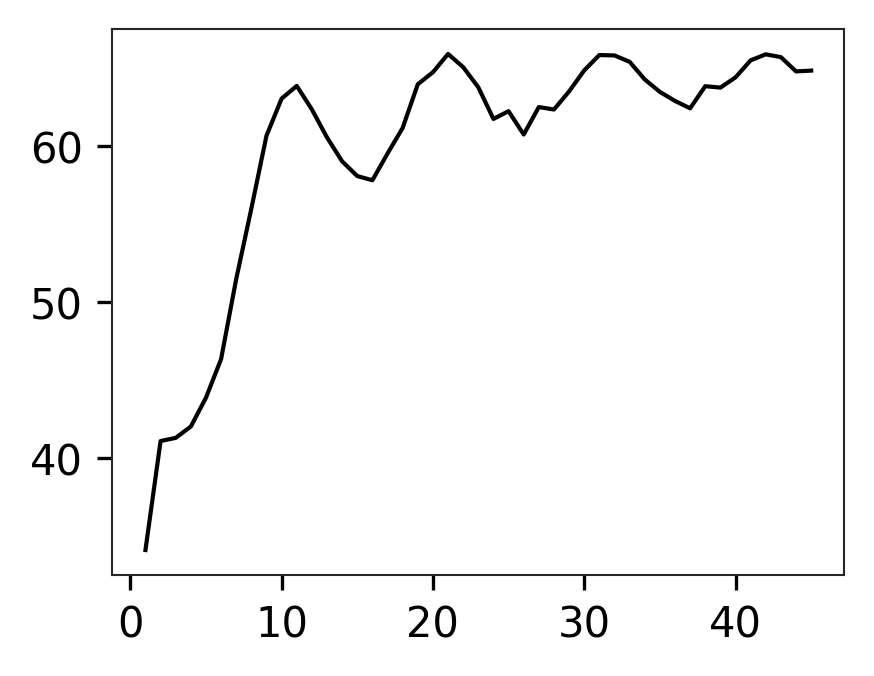

In [ ]:
import matplotlib.pyplot as plt

disc_len = 0.34
lb = np.copy(tancor)
lb[:,1] = -lb[:,0]*disc_len / np.log(lb[:,1])

lb = lb[:45]

fig = plt.figure(figsize=(8/2.54*2.2, 6/2.54), dpi=300,facecolor='w',edgecolor='k')
ax1  = fig.add_subplot(121)
ax1.plot(lb[:,0],lb[:,1],lw=1,color='black')

plt.show


np.save('Data/JanSeq/Lipfert_7p9kb_lb4.npy',lb)